# Mounting the drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


# Importing Dependencies

In [33]:
%pip install transformers
%pip install spacy
import os
import torch
import random
import warnings
import numpy as np
import transformers
import pandas as pd 
from PIL import Image
import torch.nn as nn
warnings.filterwarnings("ignore")
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Optional
from tqdm import tqdm, trange
import spacy

## For Reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

## Tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

## Device Configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the method for loading the Emogen Data

In [34]:
def load_data(data_path,data_type):
  csv_str =str("annotations/"+data_type+"_"+"caption.csv")
  img_path = os.path.join(data_path,data_type)
  mapping_csv = pd.read_csv(os.path.join(data_path,csv_str))
  image_name = {
    'image_name':img_path+'/'+mapping_csv['image_hash']+'.jpg'
  }
  captions = {
      'caption':mapping_csv['comment']
  }
  image_name_df = pd.DataFrame.from_dict(image_name)
  captions_df = pd.DataFrame.from_dict(captions)
  if data_type!="train":
    candidates = {
        'candidates':mapping_csv['candidates']
    }
    candidates_df = pd.DataFrame.from_dict(candidates)
    df = pd.concat([image_name_df,captions_df,candidates_df], axis=1)
  else:
    df = pd.concat([image_name_df,captions_df], axis=1)
  #Image.open(df['image_name'][0]) To debug if Image path is correct
  return df

# Loading the Emogen Data

In [35]:
data_dir = 'drive/MyDrive/685/sarcasm/'
train_data = load_data(data_dir,"train")
val_data = load_data(data_dir,"val")
test_data = load_data(data_dir,"test")
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1744, 2)
(50, 3)
(83, 3)


# Defining the Tokenizer

In [36]:
from pandas.core.arrays import string_
set_of_tokens = set()
tokens = []
max_len=100

for i,caption in enumerate(train_data['caption']):
  #caption = '<start> '+caption+' <end>'
  train_data['caption'][i] = caption
  caption = caption.split(' ')
  for token in caption:
    set_of_tokens.add(token)
    tokens.append(token)
set_of_tokens.add('<pad>')
set_of_tokens.add('<start>')
set_of_tokens.add('<end>')
set_of_tokens.add('<unk>')
list_of_tokens = list(set_of_tokens)
word_to_id = {}

for i,token in enumerate(list_of_tokens):
  word_to_id[token] = i

def tokenizer_decode(input_ids,skip_special_tokens=False):
  output_string = ''
  for id in input_ids:
    if list_of_tokens[id] == '<end>':
      if skip_special_tokens:
        return output_string
      else:
        output_string += list_of_tokens[id]
        return output_string    
    if list_of_tokens[id] in ['<start>','<end>','<pad>'] and skip_special_tokens:
      continue
    output_string += list_of_tokens[id]
    output_string += ' '
  return output_string[:-1]

def tokenizer_encode(input_string):
  output_ids = []
  input_tokens=['<start>']
  input_tokens.extend(list(input_string.split(' ')))

  input_tokens.append('<end>')
  if len(input_tokens)<100:
    temp=['<pad>']*(100-len(input_tokens))
    input_tokens.extend(temp)
  for token in input_tokens:
    if token in word_to_id:
      output_ids.append(word_to_id[token])
    else:
      output_ids.append(word_to_id['<unk>'])
  return output_ids

tokens = tokenizer_encode(train_data['caption'][1])
output_string = tokenizer_decode(tokens)
print(train_data['caption'][1])
print(tokens)
print(output_string)
print(train_data['caption'][1] == output_string)

I couldn't imagine a prettier car.
[3137, 74, 2408, 3059, 433, 2652, 307, 3418, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710]
<start> I couldn't imagine a prettier car. <end>
False


# Defining the Dataset Class for Torch

In [37]:
class DatasetPrep(Dataset):
    
    def __init__(self, df, 
                 transforms: Optional[Callable] = None,name=None) -> None:
        self.df = df
        self.name=name
        self.transforms = T.Compose([
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            T.Resize((256,256))
        ])
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int):
        
        image_id = self.df.image_name.values[idx]
        image = Image.open(image_id).convert('RGB')

        
        if self.transforms is not None:
            image = self.transforms(image)
        
        comments = self.df[self.df.image_name == image_id].values.tolist()[0][1:][0]
        encoded_inputs = tokenizer_encode(comments)
        sample = {"image":image.to(device),"captions": torch.Tensor(encoded_inputs).type(torch.LongTensor).to(device),"image_id":image_id}

        return sample

# Loading the dataset and defining the Data Loaders

In [38]:
batch_size = 4

train_dataset = DatasetPrep(train_data, transforms = True,name="train")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = DatasetPrep(val_data, transforms = True,name="val")
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,drop_last=True)

test_dataset = DatasetPrep(test_data, transforms = True,name="test")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,drop_last=True)

print(train_dataset[0]['captions'])
temp = train_dataset[0]['captions'].cpu().detach().numpy()
print(tokenizer_decode([2510]))#temp.astype(int)))

tensor([3137, 1475,  935, 2300, 4113, 2321, 3418, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710])
Give


torch.Size([3, 256, 256])


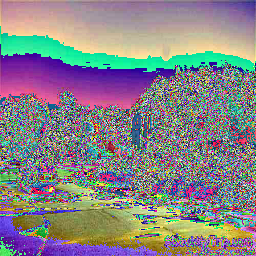

In [39]:
from torchvision import transforms
image = next(iter(train_dataloader))['image']
print(image[1].shape)
image = transforms.ToPILImage()(image[1])
display(image)


# Setting up the CNN module for extracting image features

In [40]:
class CNN(nn.Module):
    
    def __init__(self, embed_size):
        super(CNN, self).__init__()
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad_(False)
        
        modules = list(model.children())[:-1]
        self.model = nn.Sequential(*modules)
        self.embed = nn.Linear(model.fc.in_features, embed_size)
        
    def forward(self, image):
        features = self.model(image)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
                
        return features

# Setting up the RNN module for building the caption

In [41]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, embedding_dim,vocab_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(num_embeddings = vocab_size,embedding_dim = embedding_dim)
        
        self.rnn = nn.RNN(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        
    def init_hidden(self, features):
        
        return torch.autograd.Variable(features.unsqueeze(0)).to(device)
        
    def forward(self, features, captions):
        
        state = self.init_hidden(features)
        
        embed = self.embedding(captions)
                    
        rnn_out, state = self.rnn(embed, state)
                        
        outputs = self.fc(rnn_out)

        return outputs


# Sample forward pass to verify the dimensions

In [42]:
vocab_size = len(list_of_tokens)
example_batch = next(iter(train_dataloader))

image, captions = example_batch["image"], example_batch["captions"]
print(captions[0])

print(tokenizer_decode(captions[0].detach().cpu().numpy().astype(int),skip_special_tokens=True))

encoder = CNN(embed_size = 512).to(device)
decoder = RNN(input_size = 512, hidden_size = 512, embedding_dim=512, vocab_size = vocab_size).to(device)

features = encoder(image)
embed = decoder(features,captions)

print("Image Transformation: ", image.shape, " --> ", features.shape)
print("Captions Transformation: ", captions.shape, " --> ", embed.shape)

tensor([3137, 1475,  935, 2300, 4113, 2321, 3418, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710, 3710,
        3710, 3710, 3710, 3710])
Yes please sit by me 
Image Transformation:  torch.Size([4, 3, 256, 256])  -->  torch.Size([4, 512])
Captions Transformation:  torch.Size([4, 100])  -->  torch.Size([4, 100, 4325])


# Initializing the CNN (Encoder) and the RNN (Decoder)

In [43]:
encoder = CNN(embed_size = 512).to(device)
decoder = RNN(input_size = 512, hidden_size = 512, embedding_dim=512, vocab_size = vocab_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = torch.optim.Adam(params, lr=0.0001)

In [44]:
def calculate_val_loss(encoder,decoder):

    loss = 0
    for idx, sample in enumerate(val_dataloader):

        image, captions = torch.tensor(sample['image']).to(device), torch.tensor(sample['captions']).to(device)
        
        with torch.no_grad():       
            
            # Forward pass
            features = encoder(image)
            outputs = decoder(features, captions)

            
            # Compute the Loss
            loss += criterion(outputs.view(-1, vocab_size), 
                            captions.view(-1))
            

    return loss


# Training!

In [45]:
'''
for epoch in range(10):
    print("Epoch ",epoch)

    with tqdm(train_dataloader, unit="batches") as tepoch: #remember to change this back to train
        for sample in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            image, captions = torch.tensor(sample['image']).to(device), torch.tensor(sample['captions']).to(device)
            
            encoder.train()
            decoder.train()
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            features = encoder(image)
            outputs = decoder(features, captions)

            


            # Compute the Loss
            loss = criterion(outputs.view(-1, vocab_size), 
                            captions.view(-1))
            #acc = accuracy(outputs,captions.view(-1),5)
            #bleu = validate(val_dataloader,encoder,decoder,criterion)
            
            # Backward pass.
            loss.backward()
            
            # Update the parameters in the optimizer.
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())
    #val_loss = calculate_val_loss(encoder=encoder,decoder=decoder)
    #print("Validation Loss (over the entire validation set) = ",val_loss)
    state = {'epoch': epoch,
          'encoder': encoder,
          'decoder': decoder,
          'optimizer': optimizer}
    filename = 'checkpoint_'+str(epoch)+'.pkl'
    torch.save(state, filename)
'''


'\nfor epoch in range(10):\n    print("Epoch ",epoch)\n\n    with tqdm(train_dataloader, unit="batches") as tepoch: #remember to change this back to train\n        for sample in tepoch:\n            tepoch.set_description(f"Epoch {epoch}")\n            image, captions = torch.tensor(sample[\'image\']).to(device), torch.tensor(sample[\'captions\']).to(device)\n            \n            encoder.train()\n            decoder.train()\n            # zero the parameter gradients\n            optimizer.zero_grad()\n            \n            # Forward pass\n            features = encoder(image)\n            outputs = decoder(features, captions)\n\n            \n\n\n            # Compute the Loss\n            loss = criterion(outputs.view(-1, vocab_size), \n                            captions.view(-1))\n            #acc = accuracy(outputs,captions.view(-1),5)\n            #bleu = validate(val_dataloader,encoder,decoder,criterion)\n            \n            # Backward pass.\n            loss.bac

# Inference

In [48]:
checkpoint = torch.load('BaselineSarcasm.pkl',map_location=torch.device('cpu'))
encoder = checkpoint['encoder']
decoder = checkpoint['decoder']
encoder.eval()
decoder.eval()

df = pd.DataFrame(columns = ['image_hash', 'generated_comment','comment'])

with tqdm(test_dataloader, unit="batches") as tepoch_test:
    for sample in tepoch_test:
        image, captions = torch.tensor(sample['image']).to(device), torch.tensor(sample['captions']).to(device)
        image_id = sample['image_id']
        with torch.no_grad():       
            features = encoder(image)
            
            state = features.unsqueeze(0).to(device)
            print(state.shape)
            print(captions.shape)
            captions = torch.IntTensor([[3137],[3137],[3137],[3137]]).to(device)
            print(captions.shape)
            embed = decoder.embedding(captions)
            print(embed.shape)
            final_outputs = torch.zeros(size=(batch_size,100))
            for i in range(99):
                rnn_out, state = decoder.rnn(embed,state)
                outputs = decoder.fc(rnn_out)
                outputs = torch.squeeze(outputs,dim=1)
                output_words = torch.topk(outputs,4,dim=1).indices[:,random.randrange(4)]
                final_outputs[:,i] = output_words
                embed = decoder.embedding(output_words)
                embed = torch.unsqueeze(embed, dim=1)

            final_outputs = final_outputs.type(torch.IntTensor)

            for i in range(batch_size):
                image_hash = image_id[i].split('/')[-1][:-4]
                generated_comment = tokenizer_decode(final_outputs[i],skip_special_tokens=True)
                print('\n Generated Caption = ',generated_comment)
                original_comment = tokenizer_decode(sample['captions'][i],skip_special_tokens=True)
                print('Original Caption = ',original_comment)
                df = df.append({'image_hash' : image_hash, 'generated_comment' : generated_comment, 'comment' : original_comment}, ignore_index = True)
    df = df.to_csv('test_prediction.csv',index=False)
            

  5%|▌         | 1/20 [00:01<00:28,  1.50s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  other, arms! town, arms! town, town, don't? town, town, town, arms! arms! arms! town, located? located? heels. anyone anyone polka drum, styles team. foggy trump monster monster monster :P :P town, arms! thought thought roofs roofs forever forever wires odd true true true design. print. print. eye! eye! cutest Learn Games Unless acid bird... ago? thousands Here Here loose capacitor them decaying train funnily artsy. Sam's Sam's guess. guess. Here Bro... trip trip scary Sam's guess. adorable, styles eye! guys. drum, none upside Give smiles destined red-stripe town, arms! kidding. kidding. kidding. kidding. Uh... kidding. Uh... Uh... 
Original Caption =  That house sure has lots of <unk> on it! 

 Generated Caption =  town, arms! arms! town, town, town, don't? town, town, town, arms! arms! arms! town, located? located? heels. anyone anyone polka drum, styles team. foggy trump mo

 10%|█         | 2/20 [00:04<00:39,  2.20s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  oneis no wisdom. athletes athletes athletes remove rhinos rhinos remove depressed. setting, course course her convey convey memo! going memo! another. spot spot other, cutest cutest cutest Games polka anyone anyone polka polka polka drum, drum, complete.  subtle haha!!! special blown yikes Not rotate ahead. point, building oneis oneis building bear bear was was PICTURE. interrupted interrupted interrupted interrupted tuckered tuckered tuckered haha!!! haha!!! subtle haha!!! special subtle haha!!! windows! :p redder windows! weather! weather! weather! contained paper who's windows! around? around? around? around? red-stripe town, town, arms! arms! town, thought town, don't? don't? Sam's guess. Sam's Sam's 
Original Caption =  Is there really a <unk> or just rocks pretending to be alive? 

 Generated Caption =  other, spot event. stance stance stance athletes... bear bear was be

 15%|█▌        | 3/20 [00:07<00:43,  2.57s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  have have have have have sit Right, town, AA safe. town, were were town, located? town, don't? Poor point, Twinkies fools finally IMAGINE :p Learn eye! eye! eye! stoned. stoned. stoned. still! drum, drum, drum, styles styles styles paper Lost Lost congested congested congested far wedgie bird subpar were skirt. building oneis building mine. Poor town, town, town, don't? town, town, arms! thought town, located? town, arms! thought stoned. town, rotate ahead. ahead. Sam's Sam's guess. Here Here Here loose MACHO celebrating dirtiness stance train Dude EXACTLY slide...Mom: slide...Mom: slide...Mom: sing Dude Dude Dude dumb flood Not flood somene 
Original Caption =  Looks like a great <unk> They must be having fun... 

 Generated Caption =  oneis oneis oneis oneis oneis building bear drove adorable, Wednesday. memo! christmas christmas Surfer Ok, Ok, Learn other, cutest Games cute

 20%|██        | 4/20 [00:10<00:43,  2.72s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  other, other, other, other, cutest cutest "whatever one? Ok, alien. alien. Ballo! Here Here library! scorpion.... Hoky Hoky often want! adorable, fantastic, adorable, fantastic, nose. nose. AA pro outdoor Uh... Those Uh... Uh... bent bent pants shades weather! electric pole, care standing care care Unless ahead eyeballs convention convention ahead. Sam's smile. funnily funnily funnily depressed. setting, much much much filter cutest Flash contained contained before! listening lol! lol! faster faster swimming champions town, town, rotate ahead. ahead. Sam's guess. Here Young lying Twist. paddle bird... paddle Awesome Did Here paddle paddle black paddle bird... cats on? cats on? 
Original Caption =  he looks so lost 

 Generated Caption =  anyone anyone anyone anyone polka polka drum, none depressed. setting, setting, depressed. mini mini after. mini after. after. Ok, Flintstone

 25%|██▌       | 5/20 [00:12<00:41,  2.75s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  have sit u Awesome Awesome Ugh, trade trade side. baseball true odd wires wires wires on? clown. clown. wires odd true design. hilarious. drink wires    wires odd true design. design. hyenas hyenas here> balls. MY didn't impressive... sure. tray no most cool... purple, after. purple, most us obnoxious, plane plane Catching there. enthusiastic party Gardens Gardens plus Would spooky  wires complete. complete. build thinks wires  complete. complete. hahaha players. beside beside carving suburban suburban sun. actual about. rotate trophies impressive... town, arms! kidding. heels. heels. kidding. outdoor brown shot! wires complete. complete. hahaha hahaha 
Original Caption =  Wow! Look at those <unk> bet took a long time to plant them. 

 Generated Caption =  other, arms! smiles dumb dumb travel dumb dumb travel dumb flood rigged useful useful useful louder wires wires complete. 

 30%|███       | 6/20 [00:16<00:39,  2.86s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  oneis building town, don't? town, located? heels. kidding. Uh... And electric paintings, mind front miltary   complete. complete. complete.  complete. complete. complete. complete. hahaha complete. complete.  complete.  subtle subtle haha!!! special haha!!! weather! greeeaaaat greeeaaaat weather! electric electric electric pole, paddle polka anyone anyone polka polka drum, drum, drum, complete. wires complete. complete. build build thinks wires wires clown. yes, wires odd EXACTLY Dude not! state flood Mickey! specially depressed. runs runs hilarious. design. scary hang sit Twinkies Twinkies party adorable, drove STAMP Expecting Give smiles Reminds swim, rocks! rocks! threw threw One, threw 
Original Caption =  A lady is being <unk> who looks like she just saw a <unk> 

 Generated Caption =  oneis building town, don't? town, located? heels. kidding. Uh... And electric paintings

 35%|███▌      | 7/20 [00:18<00:35,  2.76s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  anyone town, outdoor brown Ya Ya Ya giving Ya EXACTLY Dude not! state flood Not sithis there. count tray fresh depressed. dude tray tray We've green, green, toga Learn eye! sky,  wires wires on? Give I'd mama kidding. heels. heels. anyone town, town, town, rotate town, funnily funnily funnily smile. town, don't? Poor chicken Poor Poor oneis Dude Dude Dude miss.... Dude Dude Dude skirt. Dude skirt. skirt. Dude Dude dumb flood rigged remind Here's umbrella music, swim, swim, swim, rocks! threw One, One, town, arms! arms! arms! town, town, don't? stance event. laugh. laugh. purple, brown shot! 
Original Caption =  Great art school <unk> photo 

 Generated Caption =  oneis clown. Ok, pants u u u drove adorable, fantastic, adorable, drove weight dock. building mom iPhone odd true famous true odd true true odd wires wires on? cats threw building chair. build build complete. hahaha c

 40%|████      | 8/20 [00:21<00:32,  2.69s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  anyone anyone polka drum, none upside upside Games Give boards wonderful... wonderful... wonderful... wisdom. wonderful... ratio funnily funnily week!! funnily depressed. anything Despite green, green, green, lady? party Gardens Gardens Gardens Q Q public public Give state dumb congested Lost distorted All All Learn state dumb stand plain plain sure. toilet Ballo! Learn state dumb dumb stand stand BBQ rat Disneyworld! Disneyworld! green. green. train carving carving complete. hahaha festivities desk desk  wires complete.  haha!!! weather! weather! weather! =/ monkey? passed passed NIGHT'S NIGHT'S dinner! dinner! today. today. 10 smiles dumb travel dumb state flood Mickey! specially 
Original Caption =  Oh, a <unk> and a <unk>  

 Generated Caption =  other, other, cutest lump skirt. James. James. distorted kidding. heels. anyone anyone anyone polka hope....lol owls Twinkies Tw

 45%|████▌     | 9/20 [00:23<00:29,  2.66s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  heels. rocks subtle haha!!! haha!!! Games Learn Ok, Learn Learn eye! Learn cutest other, arms! smiles dirtiness nose. shave suburban sun. suburban shave were spooky loose loose stupid dude depressed. anything /great/ anything anything actual dude's dude's paintings, paintings, monster monster paintings, mind front front bro. front miltary engaging engaging destined threw One, threw threw threw STAMP butts. STAMP STAMP trump. trump. trump. town, arms! thought thought thought stoned. stoned. plates stoned. thought it. smile. town, red-stripe town, arms! arms! arms! go? town, arms! arms! town, thought stoned. Uh... subpar subpar paper head portion portion pants. sandwich. her LOL! 
Original Caption =  <unk> that glass building, the <unk> looks like its floating in <unk> air waiting to <unk> <unk> haha 

 Generated Caption =  heels. rocks subtle haha!!! haha!!! Games Learn Ok, Lea

 50%|█████     | 10/20 [00:26<00:27,  2.71s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  other, spot other, spot Christmas killer killer pondering forecaster countries. Gardens plus plus Would Learn Learn Learn Ok, Unless acid bird... acid Unless acid Unless Unless Unless styles eye! eye! Learn other, other, cutest lump weather! greeeaaaat suburban sun. actual cell gender! London, picked Chirp! town, town, don't? town, arms! arms! go? heels. heels. rocks rocks heels. heels. kidding. outdoor kidding. outdoor kidding. kidding. Uh... And And paper poops poops Here goofy angel angel state state state dumb flood flood flood Bro... Right, sea vocals difference forest, called far far depressed. runs forecaster forecaster monster. brambly design. beauty alien. 
Original Caption =  This guy looks like a <unk> <unk>  

 Generated Caption =  other, spot other, spot Christmas killer killer pondering forecaster countries. Gardens plus plus Would Learn Learn Learn Ok, Unless ac

 55%|█████▌    | 11/20 [00:32<00:34,  3.80s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  other, other, spot other, other, mental other, spot spot event. event. spot spot spot other, spot Twinkies spot spot Twinkies spot Twinkies polka anyone anyone Netflix skies, front, Here meant meant meant point, point, Twinkies spot event. event. spot event. event. spot christmas christmas christmas Lego's at? One, One, wires complete. complete.  subtle subtle subtle windows! weather! Games Games upside quite quite quite thought it. it. smile. in. town, located? kidding. outdoor brown brown brown girraffe's at? squatting Kung heels. kidding. heels. distorted here> here> bare place far depressed. red. Very going going going going going curly curly 
Original Caption =  A bunch of people being <unk> 

 Generated Caption =  other, other, spot other, other, mental other, spot spot event. event. spot spot spot other, spot Twinkies spot spot Twinkies spot Twinkies polka anyone anyone

 60%|██████    | 12/20 [00:35<00:27,  3.42s/batches]

 other, arms! arms! other, other, mental other, arms! arms! other, spot other, other, cutest other, arms! town, town, rotate ahead. ahead. Sam's smile. in. in. town, town, arms! thought smile. in. smile. smile. in. smile. in. in. smile. smile. smile. in. skirt. blue; goofy Dude kidding. heels. kidding. outdoor outdoor outdoor town, located? town, town, rotate trophies 25k eyes*. special paintings, monster paintings, paintings, true famous famous something doesn't something something rotate donald donald donald town, arms! arms! town, located? kidding. Uh... Uh... Uh... Those sportscar somene tripping intricate. funnily metal metal town, town, don't? town, don't? town, located? 
Original Caption =  The cute puppy just couldn't get <unk> <unk> in. 


 65%|██████▌   | 13/20 [00:41<00:28,  4.10s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  other, spot event. stance stance event. event. stance beef? event. stance stance event. event. spot other, cutest cutest lump weather! electric weather! contained useful! useful! useful! Ooh, camel! actual Anything curly curly going haha!!! subtle parties neighborhood. neighborhood. down! neighborhood. working. Expecting Give smiles Pops plate.. plate.. yay! fine didnt fine fine didnt didnt none Not! paddle paddle paddle bird... acid acid acid wisdom. windows! windows! redder windows! :p redder :p :p brother, brother, shoe shoe interrupted interrupted tuckered guys, sharkplane? lady? comedy chess Those kidding. speeding town, town, rotate rotate ahead. ahead. Ya town, rotate town, located? town, 
Original Caption =  <unk> <unk> out 

 Generated Caption =  other, spot event. stance stance event. event. stance beef? event. stance stance event. event. spot other, cutest cutest lu

 70%|███████   | 14/20 [00:47<00:28,  4.76s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  heels. graffiti polka wires complete. complete. build thinks  complete. complete. build adorable, adorable, fantastic, Wednesday. memo! going memo! vocals drink! suburban sun. suburban suburban greeeaaaat greeeaaaat greeeaaaat green? decaying one? Ok, one? decaying all!" special special subtle parties Lego's flag miss.... Young Here Young lying something songs. equal they're go? decaying existed underpants. after. mini after. sun. sun. day. Mommy Mommy Mommy Dude Dude skirt. Ya giving Ya town, town, arms! kidding. Uh... Uh... Learn Learn players funnily week!! trade trade sure. louder louder Sam's Sam's town, don't? don't? don't? Sam's ahead. stupid going haha!!! haha!!! haha!!! haha!!! 
Original Caption =  those <unk> are nice 

 Generated Caption =  heels. graffiti polka wires complete. complete. build thinks  complete. complete. build adorable, adorable, fantastic, Wednesda

 75%|███████▌  | 15/20 [00:49<00:20,  4.12s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  anyone town, located? heels. heels. graffiti heels. kidding. kidding. kidding. Uh... And Uh... Uh... Uh... maybe maybe Reminds surrrre able surrrre surrrre path. toga Trump's am am bro. bro. bro. thinks   wires odd alien. alien. Ballo! Ballo! state Give Give smiles Pops Pops polka drum, none upside quite it'll carving carving oneis oneis building oneis oneis building building chair. build listening pool listening listening car Sam's ahead. ahead. Sam's smile. smile. town, arms! kidding. heels. kidding. outdoor town, !dodge building oneis Dude Dude miss.... miss.... offices travel too travel travel travel cell shallow Give state Give boards 
Original Caption =  <unk> We Are 

 Generated Caption =  oneis building oneis no no tray no oneis oneis oneis building chair. Miss Miss Miss bird... bird... paddle bird... blessing bird... bird... blessing athletes... though. ! ! photo phot

 80%|████████  | 16/20 [00:55<00:17,  4.49s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  oneis clown. Ok, Ok, Learn town, red-stripe red-stripe red-stripe adorable, drove STAMP STAMP Expecting Uh... Uh... kidding. kidding. Uh... Those kidding. speeding speeding kidding. outdoor kidding. Uh... And And poops paper hyenas green? Dude miss.... miss.... miss.... corn bro. monster monster staged athletes... though. ! were grocery?! were were happened happened were spooky weather! weather! =/ wow wow convention vocals louder wires complete. hahaha hahaha complete.  complete. chess chess rotate chess drum, anyone anyone anyone Netflix Anyone Bilbo actual sand sand shave fast, fast, polka complete. hahaha complete.  complete. chess chess chess photo sun. photo chess trophies 
Original Caption =  Um, I thought you <unk> the <unk> not the <unk> <unk> 

 Generated Caption =  anyone polka complete. complete. build thinks wires wires wires innovative Ya EXACTLY EXACTLY Dude mis

 85%|████████▌ | 17/20 [00:57<00:11,  3.79s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  heels. graffiti polka polka drum, none said... suburban shave shave suburban greeeaaaat weather! buggers! buggers! buggers! buggers! buggers! care cart, produce! produce! hiding haha!!! weather! Dogs building chair. build thinks thinks thinks destined yikes Real eye! stoned. Uh... subpar wow Yeah..green. mom iPhone coconuts! green? Dude Dude flood dumb travel travel Woah, listening car Sam's Sam's Sam's depressed. himself! key literally miss.... Mommy interrupted tuckered Bro... mental Sam's located? kidding. heels. heels. heels. kidding. heels. anyone polka drum, drum, drum, complete. wires thinks innovative innovative innovative Twinkies spot Twinkies polka complete. hahaha hahaha players. players. memo! vocals hahaha hahaha 
Original Caption =  Looks like a high class <unk> to me! 

 Generated Caption =  heels. graffiti polka polka drum, none said... suburban shave shave su

 90%|█████████ | 18/20 [01:00<00:06,  3.43s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  other, spot other, other, cutest cutest lump weather! electric pole, public Give state state state state Give smiles destined trump. distorted heels. kidding. outdoor town, !dodge laugh. purple, brown shot! ordered. ordered. mom iPhone iPhone fun. another. another. true athletes... butts. butts. threw One, Ballo! town, arms! town, town, arms! town, outdoor kidding. Uh... kidding. Uh... kidding. Uh... And And poops town, funnily kidding. heels. kidding. Uh... And electric weather! buggers! build complete.  wires odd true athletes... bear great. clown. suits, often crafts acid bird... bird... paddle black paddle bird... blessing blessing vocals vocals memo! another. memo! overdressed 
Original Caption =  Bet they aren't having a very good time. 

 Generated Caption =  oneis no most most purple, purple, Games upside quite else. path. Bug's Yosemite Yosemite Yosemite Yosemite was 

 95%|█████████▌| 19/20 [01:05<00:03,  3.98s/batches]

torch.Size([1, 4, 512])
torch.Size([4, 100])
torch.Size([4, 1])
torch.Size([4, 1, 512])

 Generated Caption =  heels. anyone town, public town, town, arms! arms! arms! town, arms! town, town, don't? Poor point, point, building building town, arms! kidding. heels. anyone town, public What's What's What's town, town, arms! kidding. town, town, don't? stance town, arms! town, town, rotate rotate ahead. point, building oneis building mine. Dude miss.... miss.... funnily airline wheels heels. anyone anyone errant, eye, Ooh, chips barbed something? lying lying Such Such depressed. setting, course count sword sword flood trip scary kidding. outdoor kidding. clown. clown. photograph? drum, still! still! still! athletes... drove STAMP outfit Real Real town, red-stripe town, arms! arms! go? 
Original Caption =  Hey buddy, you're supposed to <unk> the truck <unk> not the walls. You aren't a house <unk> 

 Generated Caption =  heels. anyone town, public town, town, arms! arms! arms! town, arms! to

100%|██████████| 20/20 [01:08<00:00,  3.41s/batches]

Original Caption =  The <unk> of the <unk> has now <unk> 

 Generated Caption =  heels. kidding. outdoor brown stance athletes... butts. butts. threw memo! memo! memo! memo! christmas spot Twinkies polka complete. complete. build adorable, adorable, problem problem remove depressed. mini Dogs Dogs weather! Dogs Dogs weather! Dogs Dogs cool... cool... cool... building suburban suburban suburban suburban sun. sun. day. "sleeping day. shave were adult cats town, funnily kidding. kidding. Uh... Those Those Uh... subpar wow subpar subpar subpar Disneyworld! green. true stance guitar Uh... Those white-stripe station pressure rotate rotate rotate impressive... impressive... town, red-stripe red-stripe red-stripe red-stripe adorable, adorable, drove drove STAMP outfit memo! outfit outfit memo! Wednesday. memo! going memo! 
Original Caption =  That dumb kid is going to <unk> that <unk> 

 Generated Caption =  heels. kidding. outdoor brown stance athletes... butts. butts. threw memo! memo! memo!